# Influenza Trend Analysis — Project Excerpt

This notebook presents a **partial excerpt** from my comprehensive influenza surveillance analysis project.
The full version includes data ingestion from CDC ILINet & lab surveillance datasets, time‑series analysis, ARIMA forecasting, spatial mapping, and epidemiological interpretation.

**Full project repository:** https://github.com/zeyinf/full_Influenza_Trends_project

## Load & View ILINet Data

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
ilinet_data = pd.read_csv('ILINet.csv', skiprows=1)
clinical_labs_data = pd.read_csv('ICL_NREVSS_Clinical_Labs.csv', skiprows=1)
public_health_labs_data = pd.read_csv('ICL_NREVSS_Public_Health_Labs.csv', skiprows=1)

# Preprocess
# Assuming 'YEAR' and 'WEEK' are columns in your DataFrame
ilinet_data['DATE'] = pd.to_datetime(ilinet_data['YEAR'].astype(str) + ' ' +
                                    ilinet_data['WEEK'].astype(str) + ' 1', format='%Y %U %w')
clinical_labs_data['DATE'] = pd.to_datetime(clinical_labs_data['YEAR'].astype(str) + ' ' +
                                clinical_labs_data['WEEK'].astype(str) + ' 1', format='%Y %U %w')
public_health_labs_data['DATE'] = pd.to_datetime(public_health_labs_data['YEAR'].astype(str)
                      + ' ' + public_health_labs_data['WEEK'].astype(str) + ' 1', format='%Y %U %w')

# Merge the datasets on 'YEAR' and 'WEEK'
merged_data = pd.merge(ilinet_data, clinical_labs_data, on=['YEAR', 'WEEK'], how='inner')
merged_data = pd.merge(merged_data, public_health_labs_data, on=['YEAR', 'WEEK'], how='inner')

merged_data.head()

,REGION TYPE_x,REGION_x,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,...,TOTAL SPECIMENS_y,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v,A (H5),DATE
0,National,X,2023,40,2.27908,2.26141,13519,13441,X,19001,...,3064,176,16,10,3,48,0,0,0,2023-10-02
1,National,X,2023,41,2.33755,2.31454,14419,13964,X,18593,...,3067,213,22,12,5,68,0,0,0,2023-10-09
2,National,X,2023,42,2.52242,2.51633,15704,14454,X,20290,...,3416,276,26,34,12,73,0,0,0,2023-10-16
3,National,X,2023,43,2.71275,2.68605,16986,15480,X,22514,...,2934,240,36,48,14,68,0,0,0,2023-10-23
4,National,X,2023,44,2.94538,2.91431,17793,16585,X,24797,...,3172,292,41,63,13,90,0,0,0,2023-10-30


## Weekly Influenza‑Like Illness (ILI) Trend

In [23]:
def ili_metrics(df, date_col="DATE", value_col="% WEIGHTED ILI", baseline_weeks=3):
    """
    Compute key epidemiological indicators for weekly ILI data:
      - peak_value / peak_date: maximum ILI level and when it occurred
      - baseline: early-season baseline using first `baseline_weeks` weeks
      - rise_rate_per_week: rate of increase from baseline to seasonal peak
      - auc: area under the curve (proxy for overall seasonal intensity)

    Assumptions:
      - Data contains weekly time-series
      - Data is already cleaned and sorted by date
    """

    # Keep only date and value columns, sort by date, reset index
    d = df[[date_col, value_col]].dropna().sort_values(date_col).reset_index(drop=True)

    # Ensure we have enough data to compute metrics
    if d.empty or len(d) < 2:
        raise ValueError("Not enough data to compute ILI metrics.")

    # Peak value and timing
    peak_idx = d[value_col].idxmax()
    peak_value = float(d.loc[peak_idx, value_col])
    peak_date = pd.to_datetime(d.loc[peak_idx, date_col])

    # Baseline: average of first baseline_weeks
    bw = max(1, min(baseline_weeks, len(d)))  # avoid out-of-range errors
    baseline = float(d.loc[:bw-1, value_col].mean())

    # Weekly rise rate: (peak - baseline) / weeks_to_peak
    weeks_to_peak = max(1, peak_idx)  # avoid division by zero
    rise_rate_per_week = (peak_value - baseline) / weeks_to_peak

    # Area under the curve (AUC) as intensity proxy
    import numpy as np
    auc = float(np.trapz(y=d[value_col].values, x=np.arange(len(d))))

    return {
        "peak_value": peak_value,
        "peak_date": peak_date,
        "baseline": baseline,
        "rise_rate_per_week": rise_rate_per_week,
        "auc": auc
    }

In [24]:
# Compute seasonal metrics for the excerpt dataset
metrics = ili_metrics(ilinet_data, date_col="DATE", value_col="% WEIGHTED ILI")
print("ILI Seasonal Metrics:", metrics)

ILI Seasonal Metrics: {'peak_value': 6.7962, 'peak_date': Timestamp('2023-12-25 00:00:00'), 'baseline': 2.379683333333333, 'rise_rate_per_week': 0.36804305555555555, 'auc': 149.82191500000002}


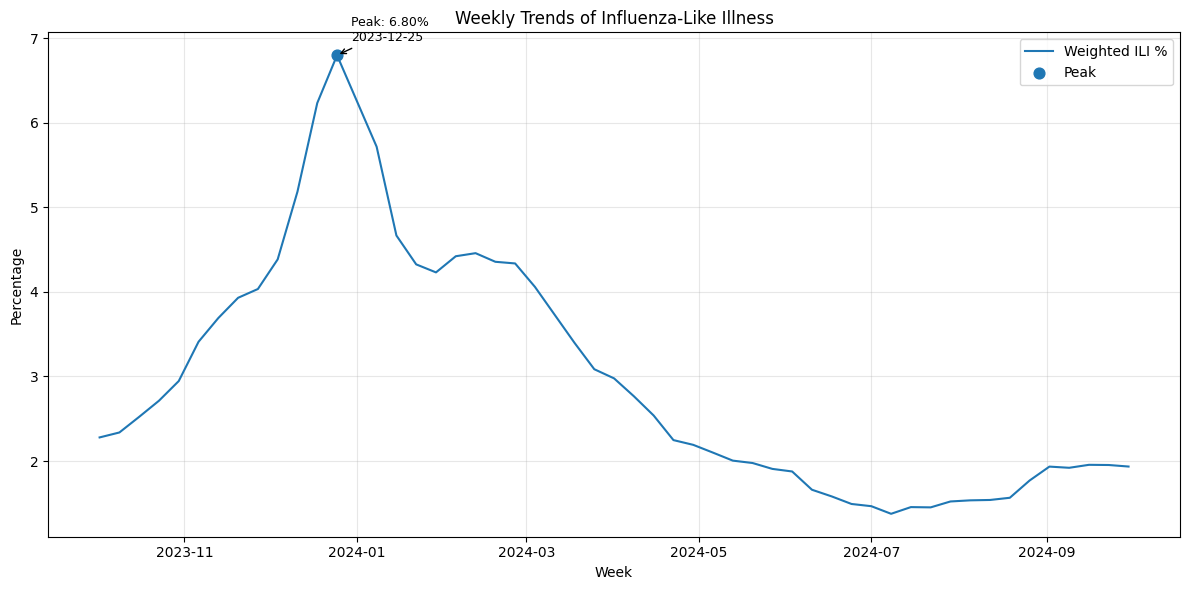

In [25]:
# Weekly trends of ILI
plt.figure(figsize=(12, 6))
plt.plot(merged_data['DATE'], merged_data['% WEIGHTED ILI'], label='Weighted ILI %')

# Annotate seasonal peak
plt.scatter([metrics["peak_date"]], [metrics["peak_value"]], s=60, label="Peak")
plt.annotate(
    f"Peak: {metrics['peak_value']:.2f}%\n{metrics['peak_date'].date()}",
    xy=(metrics["peak_date"], metrics["peak_value"]),
    xytext=(10, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1),
    fontsize=9
)
plt.title('Weekly Trends of Influenza-Like Illness')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation
ILI increases through fall and peaks in late December—consistent with seasonality. The smoothed trend suggests a sustained rise, not noise. The full project adds regional comparisons, forecasting, and policy context.

---

In the full notebook, this section is followed by:
- Regional comparisons
- Forecasting using ARIMA and moving averages
- Public health interpretation for each part

**See repository for full workflow →** 
https://github.com/zeyinf/full_Influenza_Trends_project